In [1]:
# Front Matter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cmasher as cm
import energyGain as eg

from flasc import floris_tools as ftools
from examples_smarteole.models import load_smarteole_floris
from flasc.visualization import plot_floris_layout, plot_layout_only, plot_layout_with_waking_directions
from floris.tools.visualization import visualize_cut_plane
from windrose import WindroseAxes

This repository introduces [energyGain](https://github.com/CLTodd/energyGain) capabilities by illustrating their use on a data set taken from a real field campaign of wake steering which has been made open-source.

The raw data comes from the [SMARTEOLE Wind Farm Control open data set](https://zenodo.org/record/7342466) and is a field campaign carried out on the 7-turbine wind farm at (Sole du Moulin Vieux, located in France). This data set has been obtained by ENGIE Green in the scope of French national project SMARTEOLE (grant no. ANR-14-CE05-0034). The publication about the test is available online [here](https://wes.copernicus.org/articles/6/1427/2021/wes-6-1427-2021.html).
  
This notebook begins with the post-processed version of this data, as dileneated in the FLASC [smarteole example notebooks](https://github.com/NREL/flasc/tree/main/examples_smarteole).


In [2]:
df_scada = pd.read_feather("df_scada_data_60s_filtered_and_northing_calibrated.ftr")

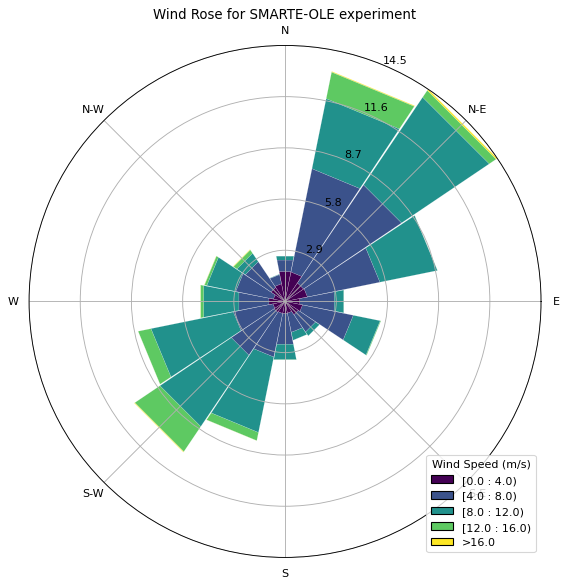

In [3]:
ax = WindroseAxes.from_ax()
ax.bar(df_scada['wd_smarteole'], 
       df_scada['ws_smarteole'],
       normed=True, 
       opening=0.98, 
       edgecolor='white',
       bins=np.arange(0,20,4),
       lw=0.1)
ax.legend(title='Wind Speed (m/s)', loc='lower right')
ax.set_title("Wind Rose for SMARTE-OLE experiment")
plt.show()

Load the FLORIS model (the FlorisInterface object), defaulting to the Gauss–curl hybrid (GCH) wake model. Other cmmon options are `cc`, `jensen` and `turbopark`. Here, uncertainty (`wd_std`) is the standard deviation in the inflow wind direction in degrees (defaults to 0.0).


In [4]:
fi = load_smarteole_floris(wake_model="gch", wd_std=0.0)
df_upstream = ftools.get_upstream_turbs_floris(fi)

Since the following methods require choosing a way to handle missingness, a further explanation of missingness should be done. For example, visualizations that examine spatial density of missingv alues, the time intervals where each turbine had missing values, and potential periodicity of missingness could be informative. Here, we just look at the number of turbines missing power measurements as a function of time.

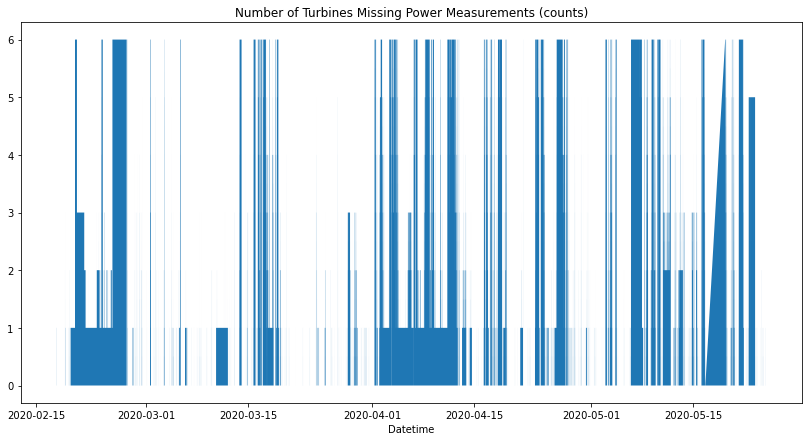

In [5]:
test_turbines = [4,5]
reference_turbines = [0,1,2,6]

# number of missing power measurements at each time stamp
df_scada['numMissing'] = df_scada[[f'pow_{i:03d}' for i in test_turbines+reference_turbines]].isna().sum(axis=1)
df_scada['anyMissing'] = np.where(df_scada['numMissing']>0,1,0)

fig1, ax1 = plt.subplots(figsize=(14,7))
ax1.fill_between(df_scada['time'], df_scada['numMissing'],0, lw=0.1)
ax1.set_title('Number of Turbines Missing Power Measurements (counts)')
ax1.set_xlabel('Datetime')
plt.show()

The way `energyGain` is currently implemented, we deal with missingness by imputing bin-specific turbine averages for missing power measurements ('bin' as in wind-condition bin)

We will also need a probability density for the wind conditions for these methods. We'll approximate this with an empirical joint wind-speed and wind-direction joint probability mass function (PMF) based on long term wind condition data for the experimental site. 

In [6]:
wind = pd.read_csv("C:/Users/ctodd/Documents/GitHub/NREL/Ablaincourt-LT-climate-80m.csv")

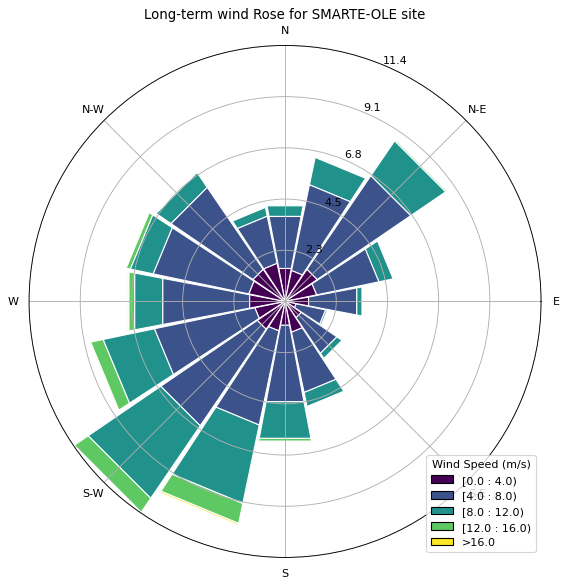

In [7]:
ax = WindroseAxes.from_ax()
ax.bar(wind['wind_direction_80m'], 
       wind['wind_speed_80m'],
       normed=True, 
       opening=0.95, 
       edgecolor='white',
       bins=np.arange(0,20,4))
ax.legend(title='Wind Speed (m/s)', loc='lower right')
ax.set_title("Long-term wind Rose for SMARTE-OLE site")
plt.show()

To do this, a decision needs to be made about the edges/widths of the wind condition bins. `energyGain` will use these bin edges to calculate the PMF. **Note to self: This is still the proprietary data. Replace with with the uncorrected data before publishing**.

In [8]:
wind_direction_bins = np.arange(205,221,1)
wind_speed_bins = np.arange(0,21,1)

**Bins do not need to be uniform width*

Now we can create or energyGain object.

In [9]:
eg_smarteole = eg.energyGain(scada = df_scada,
                          upstream = df_upstream,
                          testTurbines = test_turbines,# 4, 5
                          referenceTurbines = reference_turbines,# 0, 1, 2, 6
                          wdColScada = "wd_smarteole",
                          wsColScada = "ws_smarteole",
                          directionBins = wind_direction_bins,# 205, 206,...,220
                          speedBins = wind_speed_bins,# 0, 1, 2,...,20
                          wdColWind = 'wind_direction_80m',
                          wsColWind = 'wind_speed_80m',
                          wind = wind)

In [13]:
pr = eg_smarteole.TNOpowerRatio()

ValueError: could not convert string to float: 'baseline'

In [11]:
temp = eg_smarteole.TNOaverageTurbinePower('baseline')

In [12]:
temp['dfWithBins']

,directionBin,speedBin,time,control_mode,totalFarmPower,turbine,power,turbineLabel
0,220,9,2020-02-18 06:30:00,baseline,7247.134277,0,1652.327026,reference
1,219,10,2020-02-18 06:32:00,baseline,7019.254883,0,1405.162964,reference
2,220,9,2020-02-18 06:42:00,baseline,7287.888184,0,1565.467041,reference
3,220,9,2020-02-18 06:45:00,baseline,7562.684570,0,1413.720947,reference
4,220,9,2020-02-18 06:46:00,baseline,6961.610840,0,1504.744995,reference
...,...,...,...,...,...,...,...,...
51421,220,8,2020-05-22 07:19:00,controlled,3661.768066,5,466.516998,test
51422,220,8,2020-05-22 07:23:00,controlled,3553.714844,5,527.479980,test
51423,220,8,2020-05-22 07:28:00,controlled,2978.109863,5,347.295013,test
51424,220,7,2020-05-22 07:29:00,controlled,2975.690918,5,439.907013,test
